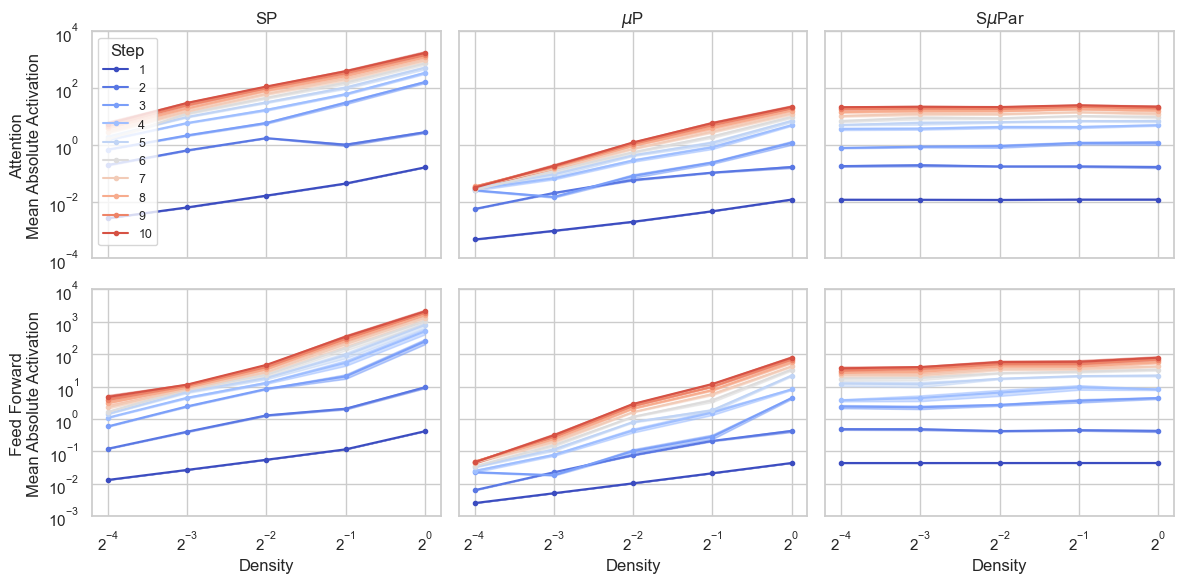

In [96]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
sns.set(style='whitegrid')


class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

layer_types = [
    # ('token_embedding_act_abs_mean', 'Word Embedding', (1e-2, 3e-2)),
    ('attn_act_abs_mean', 'Attention', (1e-4, 1e4)),
    ('mlp_act_abs_mean', 'Feed Forward', (1e-3, 1e4)),
    # ('lm_head_act_abs_mean', 'Output Logits', (1e-1, 1.5e1)),
]
parameterizations = [
    ('sp', 'SP'),
    ('mup', r'$\mu$P'),
    ('supar', r'S$\mu$Par'),
]
# seeds = [1]
# width = 1024
seeds = [1,2,3,4,5]
width = 2048
sparsities = [0.0, 0.5, 0.75, 0.875, 0.9375]
densities = 1 - np.array(sparsities)
t_max = 10

color_helper = MplColorHelper('coolwarm', 0, t_max)
n_cols = len(parameterizations)
n_rows = len(layer_types)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.reshape((n_rows, n_cols))

for parameterization_idx, (parameterization, parameterization_str) in enumerate(parameterizations):
    results_matrix = np.zeros((len(layer_types), t_max, len(sparsities), len(seeds))) # (layer_type, t, width, seed)
    for sparsity_idx, sparsity in enumerate(sparsities):
        for seed_idx, seed in enumerate(seeds):
            width_str = float(width) if width != 0 else int(width)
            job_name = f'width{width}_depth2_sparsity{sparsity}_seed{seed}'
            try:
                ckpt_df = pd.read_csv(os.path.join(parameterization, 'out', job_name, 'log.csv'))
            except:
                print(job_name)
            if len(ckpt_df) == 0 or ckpt_df['step'].max() == 0:
                print(job_name)
                continue
            for layer_type_idx, (layer_type, layer_type_str, ylims) in enumerate(layer_types):
                results_matrix[layer_type_idx, :, sparsity_idx, seed_idx] = ckpt_df[layer_type].dropna().values[:t_max].flatten()

    for layer_type_idx, (layer_type, layer_type_str, ylims) in enumerate(layer_types):
        row_idx = layer_type_idx
        col_idx = parameterization_idx
        ax = axes[row_idx, col_idx]
        for t in range(0,t_max):
            means = []
            stderrs = []
            for sparsity_idx, sparsity in enumerate(sparsities):
                nnz_results = results_matrix[row_idx, t, sparsity_idx][results_matrix[row_idx, t, sparsity_idx] != 0]
                means.append(nnz_results.mean())
                stderrs.append(np.std(nnz_results, ddof=1) / np.sqrt(len(nnz_results)))
            means = np.array(means)
            stderrs = np.array(stderrs)
            ax.plot(densities, means, label=f'{t+1}', color=color_helper.get_rgb(t), marker='.')
            ax.fill_between(densities, means-stderrs, means+stderrs, color=color_helper.get_rgb(t), alpha=0.5)

        ax.set_xscale('log', base=2)
        ax.set_yscale('log')
        ax.set_ylim(*ylims)
        if row_idx == 0:
            ax.set_title(parameterization_str)
            ax.xaxis.set_ticklabels([])
        elif row_idx == n_rows - 1:
            ax.set_xlabel('Density')
        if col_idx == 0:
            ax.set_ylabel(layer_type_str + '\nMean Absolute Activation')
        else:
            ax.yaxis.set_ticklabels([])
            ax.tick_params(axis='y', length=0, width=0)

axes.flatten()[0].legend(loc='upper left', fontsize=9, title='Step')

# plt.suptitle('Sparse Coordinate Check')
plt.tight_layout()
plt.show()
plt.close()